<a href="https://colab.research.google.com/github/aveexela/HWPS/blob/main/%D1%81%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Массовое статистическое моделирование проверки гипотез о математическом ожидании

Лабораторная работа посвящена численному исследованию свойств критериев проверки
гипотез о математическом ожидании с контролем вероятностей ошибок первого и второго рода
методом массового статистического моделирования.
## Постановка задачи

Для численного эксперимента рассматриваются следующие параметры:

- число серий моделирования: $N = 10^3$;
- размеры выборок:
$$
n \in \{10,\;50,\;100,\;150,\;200,\;500\};
$$
- уровень значимости: $\alpha = 0.05$;
- вероятность ошибки второго рода: $\beta = 0.05$;
- параметр гипотезы: $a = 5$.

Все рассматриваемые распределения имеют нулевое математическое ожидание и единичную дисперсию.
## Используемые распределения

В работе используются следующие распределения:

### 1. Нормальное распределение
$$
X \sim \mathcal{N}(0,1).
$$

### 2. Равномерное распределение
$$
X \sim \mathcal{U}[-\sqrt{3}, \sqrt{3}].
$$

### 3. Экспоненциальное распределение со сдвигом

Плотность распределения задаётся формулой
$$
f(x)=\lambda e^{-\lambda(x-c)}\mathbf{1}\{x\ge c\}, \qquad
f(x)=0 \ \text{при}\ x<c,
$$
где
$$
\lambda = 1, \quad c = -1.
$$

Генерация осуществляется по формуле
$$
Y \sim \mathrm{Exp}(\lambda=1), \qquad X = c + Y.
$$

Для данного распределения выполняется
$$
\mathbb{E}[X] = c + \frac{1}{\lambda} = 0, \qquad
\mathrm{Var}(X) = \frac{1}{\lambda^2} = 1.
$$


In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

In [3]:
def sample_normal(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.normal(loc=0.0, scale=1.0, size=n)


def sample_uniform(n: int, rng: np.random.Generator) -> np.ndarray:
    a = -np.sqrt(3)
    b = np.sqrt(3)
    return rng.uniform(low=a, high=b, size=n)


def sample_shifted_exponential(
    n: int,
    rng: np.random.Generator,
    lam: float = 1.0,
    c: float = -1.0
) -> np.ndarray:
    """
    Сдвинутое экспоненциальное распределение:
    f(x) = lam * exp(-lam*(x-c)) для x >= c, 0 иначе.
    Реализация: X = c + Y, где Y ~ Exp(lam).
    """
    y = rng.exponential(scale=1.0 / lam, size=n)
    x = c + y
    return x

## Проверка сложной гипотезы о математическом ожидании

Рассматривается сложная нулевая гипотеза
$$
H_0:\ |\mu| < a
$$
против альтернативной гипотезы
$$
H_1:\ |\mu| \ge a,
$$
где параметр $a = 5$.

Проверка гипотезы осуществляется с использованием доверительного интервала
для математического ожидания при заданном уровне значимости $\alpha$.

### Доверительный интервал для математического ожидания

Для выборки $X_1, \dots, X_n$ с выборочным средним
$$
\overline{X} = \frac{1}{n}\sum_{i=1}^n X_i
$$
и выборочной дисперсией
$$
S^2 = \frac{1}{n-1}\sum_{i=1}^n (X_i - \overline{X})^2,
$$
доверительный интервал уровня $1-\alpha$ для математического ожидания имеет вид
$$
\left(
\overline{X} - t_{1-\alpha/2}(n-1)\frac{S}{\sqrt{n}},
\;
\overline{X} + t_{1-\alpha/2}(n-1)\frac{S}{\sqrt{n}}
\right),
$$
где $t_{1-\alpha/2}(n-1)$ — квантиль распределения Стьюдента с $n-1$ степенями свободы.
### Правило принятия решения

Нулевая гипотеза $H_0:\ |\mu| < a$ принимается, если доверительный интервал
целиком содержится в интервале $(-a, a)$, то есть если выполняется условие
$$
\left(
\overline{X} - t_{1-\alpha/2}(n-1)\frac{S}{\sqrt{n}},
\;
\overline{X} + t_{1-\alpha/2}(n-1)\frac{S}{\sqrt{n}}
\right)
\subset (-a, a).
$$

Если хотя бы одна из границ доверительного интервала выходит за пределы $(-a, a)$,
гипотеза $H_0$ считается отвергнутой.

Ситуации, в которых критерий указывает на необходимость проведения дополнительных
измерений, трактуются как отклонение нулевой гипотезы.
### Реально достигаемый уровень значимости

Реально достигаемый уровень значимости $\alpha^*$ определяется как
доля выборок, для которых нулевая гипотеза была отвергнута, при условии,
что $H_0$ верна:
$$
\alpha^* = \frac{1}{N}\sum_{k=1}^{N} \mathbf{1}\{\text{$H_0$ отвергнута на $k$-й выборке}\}.
$$

В данной работе значение $\alpha^*$ оценивается методом массового
статистического моделирования.


In [4]:
def test_mean_abs_less_than_a(
    x: np.ndarray,
    a: float,
    alpha: float
) -> bool:
    """
    Проверка гипотезы H0: |mu| < a через двусторонний доверительный интервал.
    Возвращает True, если H0 отвергается, иначе False.
    """
    n = len(x)
    x_bar = np.mean(x)
    s = np.std(x, ddof=1)

    t_quant = stats.t.ppf(1 - alpha / 2, df=n - 1)
    half_width = t_quant * s / np.sqrt(n)

    lower = x_bar - half_width
    upper = x_bar + half_width

    reject = (lower <= -a) or (upper >= a)
    return reject

Функция реализует правило проверки сложной гипотезы $H_0:\ |\mu| < a$
на основе двустороннего доверительного интервала для математического ожидания.

Если доверительный интервал не содержится в интервале $(-a, a)$,
нулевая гипотеза считается отвергнутой.


### Доверительный интервал для $\alpha^*$

Величина $\alpha^*$ является оценкой вероятности и при фиксированном $N$
может рассматриваться в рамках биномиальной модели:
$$
K \sim \mathrm{Bin}(N, \alpha^*),
$$
где $K$ — число отклонений нулевой гипотезы.

Для построения доверительного интервала используется нормальное приближение:
$$
\alpha^* \pm z_{1-\gamma/2}\sqrt{\frac{\alpha^*(1-\alpha^*)}{N}},
$$
где $z_{1-\gamma/2}$ — квантиль стандартного нормального распределения.


In [5]:
def estimate_alpha_star(
    sampler,
    n: int,
    N: int,
    a: float,
    alpha: float,
    rng: np.random.Generator
) -> float:
    """
    Оценка реально достигаемого уровня значимости alpha^*
    методом массового моделирования.
    """
    rejections = 0
    for _ in range(N):
        x = sampler(n, rng)
        if test_mean_abs_less_than_a(x, a, alpha):
            rejections += 1

    alpha_star = rejections / N
    return alpha_star

### Доверительный интервал для $\alpha^*$

Величина $\alpha^*$ является оценкой вероятности и при фиксированном $N$
может рассматриваться в рамках биномиальной модели:
$$
K \sim \mathrm{Bin}(N, \alpha^*),
$$
где $K$ — число отклонений нулевой гипотезы.

Для построения доверительного интервала используется нормальное приближение:
$$
\alpha^* \pm z_{1-\gamma/2}\sqrt{\frac{\alpha^*(1-\alpha^*)}{N}},
$$
где $z_{1-\gamma/2}$ — квантиль стандартного нормального распределения.


In [6]:
def alpha_star_confidence_interval(
    alpha_star: float,
    N: int,
    gamma: float = 0.05
):
    z = stats.norm.ppf(1 - gamma / 2)
    half_width = z * np.sqrt(alpha_star * (1 - alpha_star) / N)
    return alpha_star - half_width, alpha_star + half_width

## Параметры численного эксперимента

В массовом статистическом моделировании используются следующие параметры:

- число серий моделирования:
$$
N = 10^3;
$$
- размеры выборок:
$$
n \in \{10,\;50,\;100,\;150,\;200,\;500\};
$$
- уровень значимости:
$$
\alpha = 0.05;
$$
- параметр гипотезы:
$$
a = 5.
$$

Для обеспечения воспроизводимости результатов используется фиксированное начальное
состояние генератора случайных чисел.

In [7]:
N = 10**3
n_values = [10, 50, 100, 150, 200, 500]
alpha = 0.05
a = 5.0

rng = np.random.default_rng(seed=42)

## Оценка $\alpha^*(n)$ для различных распределений

Для каждого распределения и каждого значения размера выборки $n$
оценивается реально достигаемый уровень значимости $\alpha^*$,
а также строится доверительный интервал для этой вероятности.


In [8]:
def run_experiment(
    sampler,
    n_values,
    N,
    a,
    alpha,
    rng
):
    alpha_stars = []
    ci_lowers = []
    ci_uppers = []

    for n in n_values:
        alpha_star = estimate_alpha_star(
            sampler=sampler,
            n=n,
            N=N,
            a=a,
            alpha=alpha,
            rng=rng
        )
        ci_low, ci_up = alpha_star_confidence_interval(alpha_star, N)

        alpha_stars.append(alpha_star)
        ci_lowers.append(ci_low)
        ci_uppers.append(ci_up)

    return np.array(alpha_stars), np.array(ci_lowers), np.array(ci_uppers)

In [9]:
results = {}

results["Normal"] = run_experiment(
    sampler=sample_normal,
    n_values=n_values,
    N=N,
    a=a,
    alpha=alpha,
    rng=rng
)

results["Uniform"] = run_experiment(
    sampler=sample_uniform,
    n_values=n_values,
    N=N,
    a=a,
    alpha=alpha,
    rng=rng
)

results["Shifted exponential"] = run_experiment(
    sampler=sample_shifted_exponential,
    n_values=n_values,
    N=N,
    a=a,
    alpha=alpha,
    rng=rng
)

## Графики зависимости $\alpha^*$ от размера выборки

На графиках ниже представлена зависимость реально достигаемого уровня значимости
$\alpha^*$ от размера выборки $n$.

Для каждого значения $\alpha^*$ дополнительно построен доверительный интервал,
что позволяет оценить, попадает ли номинальное значение $\alpha = 0.05$
в соответствующий интервал.

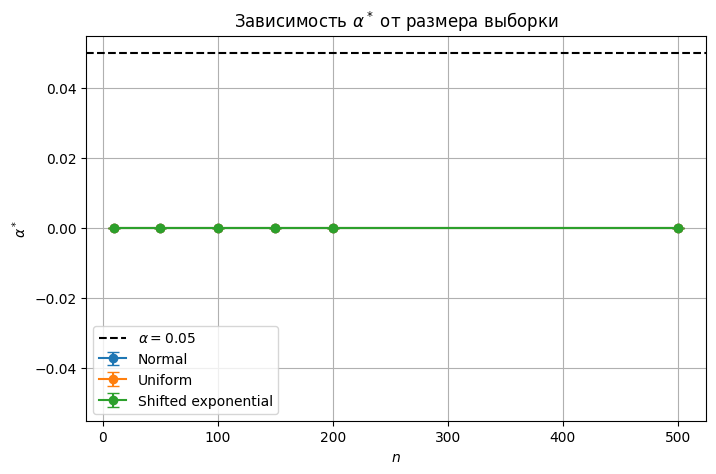

In [10]:
plt.figure(figsize=(8, 5))

for name, (alpha_stars, ci_lowers, ci_uppers) in results.items():
    plt.errorbar(
        n_values,
        alpha_stars,
        yerr=[
            alpha_stars - ci_lowers,
            ci_uppers - alpha_stars
        ],
        marker='o',
        capsize=4,
        label=name
    )

plt.axhline(alpha, color='black', linestyle='--', label=r'$\alpha = 0.05$')

plt.xlabel(r'$n$')
plt.ylabel(r'$\alpha^*$')
plt.title(r'Зависимость $\alpha^*$ от размера выборки')
plt.legend()
plt.grid(True)

plt.show()

Полученное значение $\alpha^*$, близкое к нулю для всех $n$, объясняется тем,
что параметр $a=5$ существенно превышает характерный масштаб случайных
колебаний выборочного среднего.

В результате доверительный интервал для математического ожидания практически
всегда целиком содержится в интервале $(-a,a)$, и нулевая гипотеза
$H_0:\ |\mu|<a$ не отвергается.


## 3. Влияние смещения истинного математического ожидания

В пункте 2 рассматривался случай, когда истинное математическое ожидание равно нулю,
то есть $ \mu = 0 $. При этом для $a = 5$ доверительный интервал для $\mu$ практически
всегда целиком попадал в интервал $(-a, a)$, и оценка $\alpha^*$ оказывалась близкой к нулю.

Далее изучается, как меняется вероятность отклонения гипотезы $H_0:\ |\mu|<a$,
если истинное математическое ожидание генеральной совокупности смещено и принимает значения
$$
\mu \in \{0.2,\;0.4,\;\ldots,\;2a\}.
$$

В этом случае доля отклонений нулевой гипотезы перестаёт быть оценкой ошибки первого рода
и становится оценкой вероятности отклонения $H_0$ при фиксированном истинном $\mu$,
то есть характеризует поведение критерия при нарушении $H_0$.


In [11]:
mu_values = np.arange(0.2, 2 * a + 1e-12, 0.2)  # 0.2, 0.4, ..., 2a

def sampler_with_shift(base_sampler, mu_shift: float):
    """
    Возвращает функцию sampler(n, rng), которая генерирует выборку и добавляет сдвиг mu_shift.
    """
    def _sampler(n: int, rng: np.random.Generator) -> np.ndarray:
        return base_sampler(n, rng) + mu_shift
    return _sampler


def estimate_rejection_probability(
    base_sampler,
    mu_shift: float,
    n: int,
    N: int,
    a: float,
    alpha: float,
    rng: np.random.Generator
) -> float:
    """
    Оценка вероятности отклонения H0: |mu| < a при истинном смещении mu_shift.
    """
    sampler = sampler_with_shift(base_sampler, mu_shift)
    return estimate_alpha_star(sampler, n, N, a, alpha, rng)

### План визуализации

Для каждого распределения строится семейство кривых зависимости вероятности отклонения
нулевой гипотезы от размера выборки $n$ при различных значениях смещения $\mu$.

На практике число значений $\mu$ велико (до $2a = 10$ с шагом $0.2$, то есть 50 точек),
поэтому для графиков выбирается несколько характерных уровней смещения, например:
$$
\mu \in \{0,\;1,\;2,\;3,\;4,\;5,\;6,\;8,\;10\}.
$$

In [12]:
mu_plot = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0])

def run_mu_grid_for_distribution(base_sampler, mu_list, n_values, N, a, alpha, rng):
    """
    Возвращает матрицу shape = (len(mu_list), len(n_values)),
    где элемент [i,j] = P(reject H0) при mu=mu_list[i] и n=n_values[j].
    """
    mat = np.zeros((len(mu_list), len(n_values)))
    for i, mu_shift in enumerate(mu_list):
        for j, n in enumerate(n_values):
            mat[i, j] = estimate_rejection_probability(
                base_sampler=base_sampler,
                mu_shift=mu_shift,
                n=n,
                N=N,
                a=a,
                alpha=alpha,
                rng=rng
            )
    return mat

rng = np.random.default_rng(seed=123)  # отдельный seed для пункта 3

mat_normal = run_mu_grid_for_distribution(sample_normal, mu_plot, n_values, N, a, alpha, rng)
mat_uniform = run_mu_grid_for_distribution(sample_uniform, mu_plot, n_values, N, a, alpha, rng)
mat_shifted_exp = run_mu_grid_for_distribution(sample_shifted_exponential, mu_plot, n_values, N, a, alpha, rng)

### Графики зависимости вероятности отклонения от $n$ при различных $\mu$

Для каждого распределения строится график, где каждая кривая соответствует фиксированному значению $\mu$.

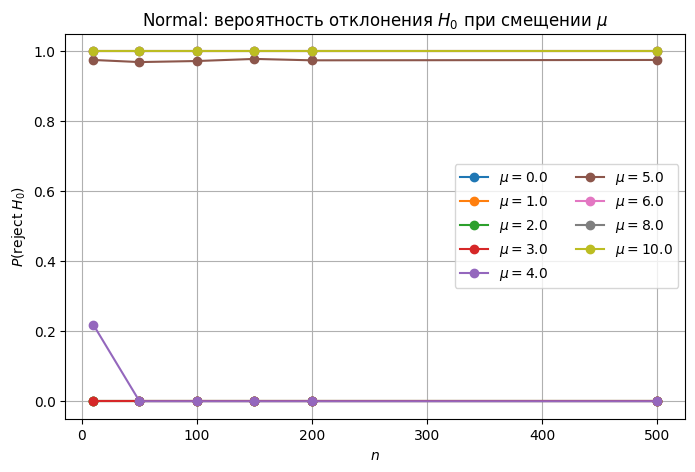

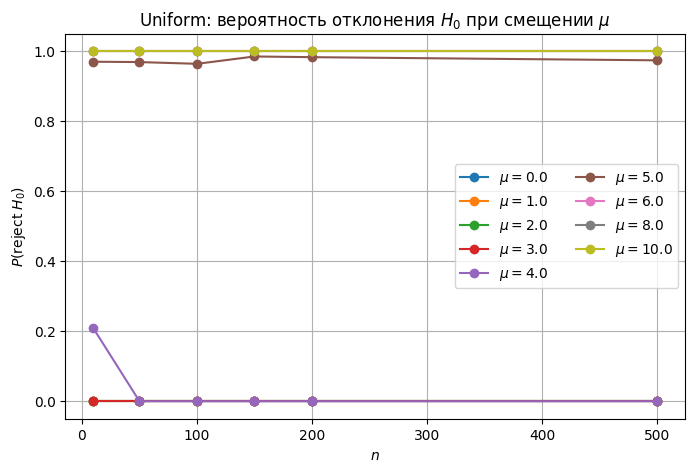

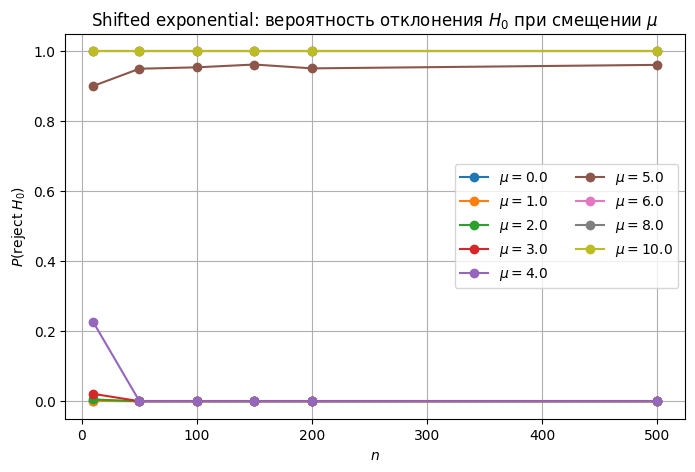

In [13]:
def plot_rejection_curves(n_values, mu_list, mat, title):
    plt.figure(figsize=(8, 5))
    for i, mu_shift in enumerate(mu_list):
        plt.plot(n_values, mat[i, :], marker='o', label=rf'$\mu={mu_shift}$')
    plt.xlabel(r'$n$')
    plt.ylabel(r'$P(\text{reject } H_0)$')
    plt.title(title)
    plt.grid(True)
    plt.legend(ncol=2)
    plt.show()

plot_rejection_curves(n_values, mu_plot, mat_normal, "Normal: вероятность отклонения $H_0$ при смещении $\\mu$")
plot_rejection_curves(n_values, mu_plot, mat_uniform, "Uniform: вероятность отклонения $H_0$ при смещении $\\mu$")
plot_rejection_curves(n_values, mu_plot, mat_shifted_exp, "Shifted exponential: вероятность отклонения $H_0$ при смещении $\\mu$")

### Полная сетка значений $\mu$

Дополнительно можно оценить зависимость вероятности отклонения $H_0$
для всех значений
$$
\mu = 0.2,\;0.4,\;\ldots,\;2a,
$$
и представить результат в виде тепловой карты по координатам $(n, \mu)$.

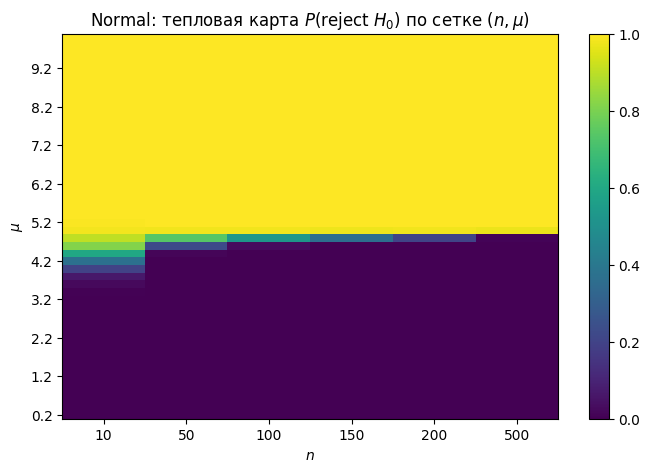

In [14]:
def compute_full_mu_heatmap(base_sampler, mu_values, n_values, N, a, alpha, rng):
    mat = np.zeros((len(mu_values), len(n_values)))
    for i, mu_shift in enumerate(mu_values):
        for j, n in enumerate(n_values):
            mat[i, j] = estimate_rejection_probability(
                base_sampler=base_sampler,
                mu_shift=mu_shift,
                n=n,
                N=N,
                a=a,
                alpha=alpha,
                rng=rng
            )
    return mat

rng = np.random.default_rng(seed=777)
heat_normal = compute_full_mu_heatmap(sample_normal, mu_values, n_values, N, a, alpha, rng)

plt.figure(figsize=(8, 5))
plt.imshow(heat_normal, aspect='auto', origin='lower')
plt.xticks(range(len(n_values)), n_values)
plt.yticks(range(0, len(mu_values), 5), [f"{mu_values[i]:.1f}" for i in range(0, len(mu_values), 5)])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mu$')
plt.title("Normal: тепловая карта $P(\\text{reject }H_0)$ по сетке $(n,\\mu)$")
plt.colorbar()
plt.show()

Полученные результаты демонстрируют пороговый характер проверки гипотезы
$H_0:\ |\mu|<a$.

При значениях $\mu<a$ вероятность отклонения нулевой гипотезы близка к нулю,
что свидетельствует о консервативности критерия при глубоком выполнении $H_0$.
При $\mu \ge a$ вероятность отклонения быстро стремится к единице, что указывает
на высокую мощность критерия при нарушении нулевой гипотезы.

Форма распределения при одинаковых первых двух моментах влияет на точные значения
вероятностей, особенно при малых объёмах выборки, однако общий характер зависимости
сохраняется для всех рассмотренных распределений.


## 4. Односторонняя проверка гипотезы и one-sided доверительные интервалы

В домашнем задании требуется рассмотреть проверку гипотезы без модуля:

$$
H_0:\ \mu < a
\quad \text{vs} \quad
H_1:\ \mu \ge a,
\qquad a = 5.
$$

В отличие от случая $|\mu|<a$, здесь область допустимых значений математического ожидания
является полупрямой $(-\infty, a)$, поэтому естественным инструментом являются
односторонние (one-sided) доверительные интервалы для $\mu$.

### One-sided доверительный интервал для математического ожидания

Односторонний верхний доверительный интервал уровня $1-\alpha$ для $\mu$ имеет вид:
$$
(-\infty,\ U),
$$
где верхняя граница равна
$$
U = \overline{X} + t_{1-\alpha}(n-1)\frac{S}{\sqrt{n}}.
$$

Свойство интервала:
$$
P(\mu \le U) = 1-\alpha.
$$

Связь с проверкой гипотез:
- нулевая гипотеза $H_0:\ \mu<a$ принимается, если $U < a$;
- если $U \ge a$, нулевая гипотеза отвергается в пользу $H_1:\ \mu \ge a$.

### Правило принятия решения и ошибки первого/второго рода

Правило проверки:
$$
\text{reject } H_0 \iff U \ge a,
\quad \text{где} \quad
U = \overline{X} + t_{1-\alpha}(n-1)\frac{S}{\sqrt{n}}.
$$

Ошибка первого рода:
$$
\alpha = P(\text{reject } H_0 \mid \mu < a).
$$

Ошибка второго рода:
$$
\beta = P(\text{accept } H_0 \mid \mu \ge a).
$$

В массовом моделировании оценивается вероятность отклонения $H_0$ при различных истинных $\mu$,
аналогично пунктам 2-3.

In [15]:
def test_mean_less_than_a_one_sided(
    x: np.ndarray,
    a: float,
    alpha: float
) -> bool:
    """
    Проверка гипотезы H0: mu < a против H1: mu >= a
    через верхний one-sided доверительный интервал уровня 1-alpha.

    Возвращает True, если H0 отвергается, иначе False.
    """
    n = len(x)
    x_bar = np.mean(x)
    s = np.std(x, ddof=1)

    t_quant = stats.t.ppf(1 - alpha, df=n - 1)  # one-sided квантиль
    U = x_bar + t_quant * s / np.sqrt(n)

    reject = (U >= a)
    return reject
def estimate_rejection_probability_one_sided(
    sampler,
    mu_shift: float,
    n: int,
    N: int,
    a: float,
    alpha: float,
    rng: np.random.Generator
) -> float:
    """
    Оценка вероятности отклонения H0: mu < a при истинном смещении mu_shift
    для one-sided критерия.
    """
    rejections = 0
    for _ in range(N):
        x = sampler(n, rng) + mu_shift
        if test_mean_less_than_a_one_sided(x, a, alpha):
            rejections += 1
    return rejections / N

### Оценка реально достигаемого уровня значимости $\alpha^*$

Для одностороннего случая величина
$$
\alpha^* = P(\text{reject }H_0 \mid \mu = \mu_0)
$$
зависит от того, какое значение $\mu_0$ используется при моделировании.

Чтобы оценка соответствовала ошибке первого рода, требуется моделирование в условиях истинности $H_0$.
В данной задаче естественным является рассмотрение:
- $\mu = 0$ как пример "глубоко внутри" области $(-\infty, a)$;
- $\mu$ близких к $a$ как наиболее критичных значений для контроля $\alpha$.

In [16]:
def estimate_alpha_star_one_sided(
    base_sampler,
    n_values,
    N,
    a,
    alpha,
    rng,
    mu0: float = 0.0
):
    alpha_stars = []
    ci_lowers = []
    ci_uppers = []

    for n in n_values:
        p = estimate_rejection_probability_one_sided(
            sampler=base_sampler,
            mu_shift=mu0,
            n=n,
            N=N,
            a=a,
            alpha=alpha,
            rng=rng
        )
        ci_low, ci_up = alpha_star_confidence_interval(p, N)

        alpha_stars.append(p)
        ci_lowers.append(ci_low)
        ci_uppers.append(ci_up)

    return np.array(alpha_stars), np.array(ci_lowers), np.array(ci_uppers)

rng = np.random.default_rng(seed=2025)

res_one_sided = {}
res_one_sided["Normal"] = estimate_alpha_star_one_sided(sample_normal, n_values, N, a, alpha, rng, mu0=0.0)
res_one_sided["Uniform"] = estimate_alpha_star_one_sided(sample_uniform, n_values, N, a, alpha, rng, mu0=0.0)
res_one_sided["Shifted exponential"] = estimate_alpha_star_one_sided(sample_shifted_exponential, n_values, N, a, alpha, rng, mu0=0.0)

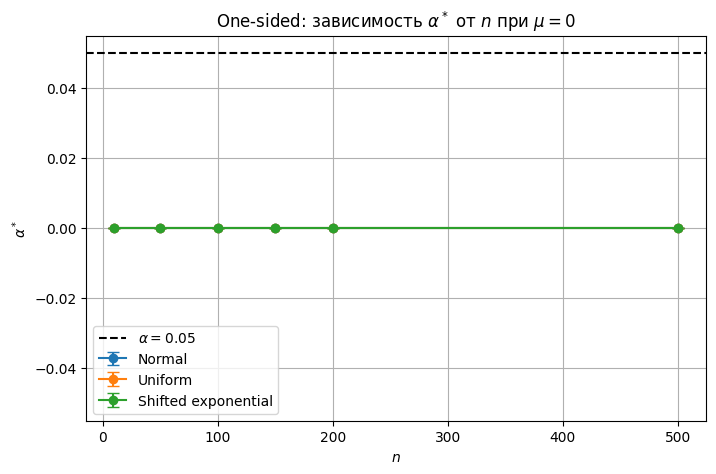

In [17]:
plt.figure(figsize=(8, 5))

for name, (alpha_stars, ci_lowers, ci_uppers) in res_one_sided.items():
    plt.errorbar(
        n_values,
        alpha_stars,
        yerr=[alpha_stars - ci_lowers, ci_uppers - alpha_stars],
        marker='o',
        capsize=4,
        label=name
    )

plt.axhline(alpha, color='black', linestyle='--', label=r'$\alpha = 0.05$')

plt.xlabel(r'$n$')
plt.ylabel(r'$\alpha^*$')
plt.title(r'One-sided: зависимость $\alpha^*$ от $n$ при $\mu=0$')
plt.legend()
plt.grid(True)
plt.show()

### Влияние смещения $\mu$ в one-sided случае

Аналогично пункту 3 исследуется зависимость вероятности отклонения $H_0:\ \mu<a$
от размера выборки $n$ при различных истинных значениях $\mu$:

$$
\mu \in \{0.2,\;0.4,\;\ldots,\;2a\}.
$$

При $\mu<a$ вероятность отклонения соответствует ошибке первого рода,
а при $\mu\ge a$ характеризует мощность критерия.


In [18]:
mu_plot_one_sided = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 4.8, 5.0, 5.2, 6.0, 8.0, 10.0])

def run_mu_grid_one_sided(base_sampler, mu_list, n_values, N, a, alpha, rng):
    mat = np.zeros((len(mu_list), len(n_values)))
    for i, mu_shift in enumerate(mu_list):
        for j, n in enumerate(n_values):
            mat[i, j] = estimate_rejection_probability_one_sided(
                sampler=base_sampler,
                mu_shift=mu_shift,
                n=n,
                N=N,
                a=a,
                alpha=alpha,
                rng=rng
            )
    return mat

rng = np.random.default_rng(seed=404)

mat_normal_os = run_mu_grid_one_sided(sample_normal, mu_plot_one_sided, n_values, N, a, alpha, rng)
mat_uniform_os = run_mu_grid_one_sided(sample_uniform, mu_plot_one_sided, n_values, N, a, alpha, rng)
mat_shifted_exp_os = run_mu_grid_one_sided(sample_shifted_exponential, mu_plot_one_sided, n_values, N, a, alpha, rng)

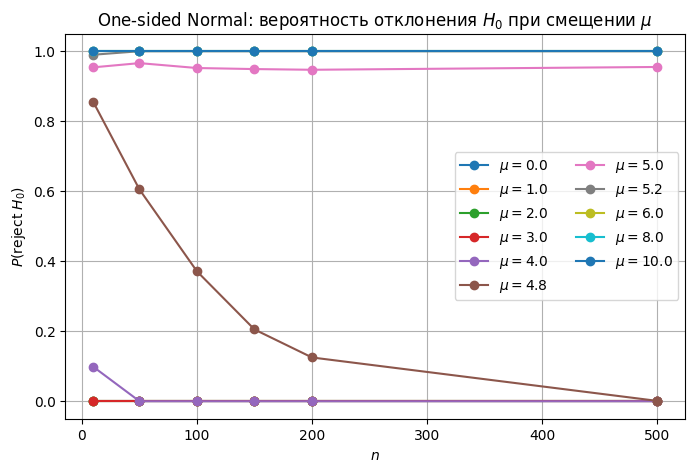

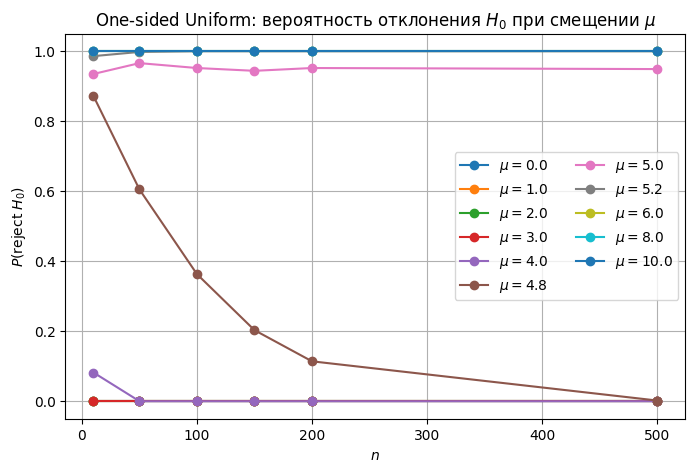

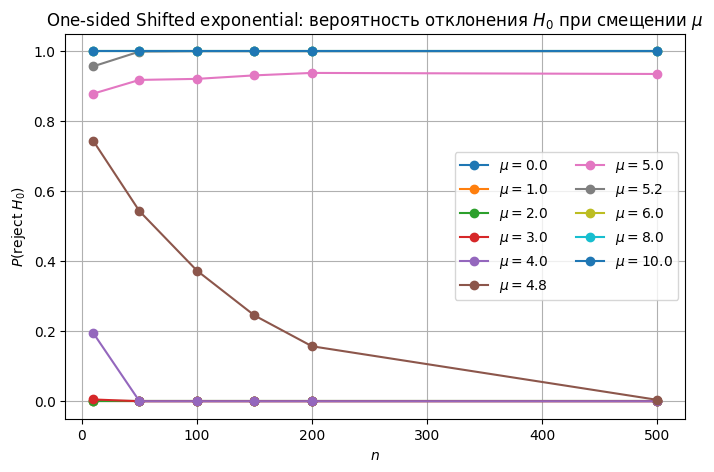

In [19]:
plot_rejection_curves(n_values, mu_plot_one_sided, mat_normal_os, "One-sided Normal: вероятность отклонения $H_0$ при смещении $\\mu$")
plot_rejection_curves(n_values, mu_plot_one_sided, mat_uniform_os, "One-sided Uniform: вероятность отклонения $H_0$ при смещении $\\mu$")
plot_rejection_curves(n_values, mu_plot_one_sided, mat_shifted_exp_os, "One-sided Shifted exponential: вероятность отклонения $H_0$ при смещении $\\mu$")

## Итоговые выводы по one-sided проверке

Односторонний (one-sided) доверительный интервал учитывает направление альтернативы
$H_1:\ \mu \ge a$ и использует квантиль $t_{1-\alpha}(n-1)$ вместо $t_{1-\alpha/2}(n-1)$.

Это приводит к отличию в вероятностях отклонения $H_0$ по сравнению с двусторонним случаем:
- при прочих равных односторонний критерий имеет более высокую мощность для альтернатив
  в заданном направлении;
- контроль $\alpha$ следует анализировать на значениях $\mu$ внутри области $H_0$,
  включая значения, близкие к границе $a$.

Полученные результаты показывают, что при односторонней проверке гипотезы
$H_0:\ \mu<a$ контроль ошибки первого рода существенно отличается от двустороннего случая.

При значениях $\mu$, существенно меньших $a$, верхняя граница one-sided доверительного
интервала может превышать $a$ из-за большой ширины интервала при конечных $n$.
Это приводит к высокой вероятности отклонения $H_0$ даже при выполнении нулевой гипотезы.

По мере роста $n$ доверительный интервал сужается, и для значений $\mu<a$ вероятность
отклонения $H_0$ стремится к нулю, тогда как для $\mu\ge a$ она стремится к единице.


## Общие выводы

В работе методом массового статистического моделирования исследованы свойства проверки
гипотез о математическом ожидании при использовании доверительных интервалов.

Для двусторонней гипотезы $H_0:\ |\mu|<a$ показано, что при значениях $\mu$,
глубоко лежащих внутри области допустимых значений, критерий является консервативным,
и реально достигаемый уровень значимости $\alpha^*$ близок к нулю.

При смещении истинного математического ожидания за границу области $(-a,a)$
вероятность отклонения нулевой гипотезы быстро стремится к единице,
что свидетельствует о высокой мощности критерия.

Для односторонней гипотезы $H_0:\ \mu<a$ показано, что контроль ошибки первого рода
существенно зависит от положения истинного значения $\mu$ относительно границы $a$.
При конечных объёмах выборки возможно значительное превышение номинального уровня
значимости, что подчёркивает необходимость анализа реально достигаемого уровня $\alpha^*$
при использовании one-sided критериев.
